# Vision Embeddings

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vit_b_16 as vit_model
from torchvision.models import ViT_B_16_Weights as vit_model_weights
from tqdm.notebook import tqdm
import PIL 
from PIL import Image

In [8]:


class ViT(nn.Module):
    
    #Constructor
    def __init__(self):
        super(ViT, self).__init__()
        
        #Load the Pretrained Model
        self.ViT_Weights = vit_model_weights(vit_model_weights.DEFAULT)
        self.ViT_Transforms = self.ViT_Weights.transforms()
        self.model = vit_model(weights=self.ViT_Weights)
        
        #Does not require training, so set the Gradients to False
        for param in self.model.parameters():
            param.requires_grad = False
            
        #Hook Variables
        self.Features = {}
        self.hook = self.model.encoder.ln.register_forward_hook(self.get_features('last_hidden_state'))

    #Hook Registration
    def get_features(self, name):
        def hook(model, input, output):
            self.Features[name] = output[:,0,:].detach()
        return hook
    
    def forward(self, batches, paths_dict, _image=None, training = True):
        if training:
            Vision_Embeddings = []
            Image_Ids = []
            for batch in tqdm(batches):
                image_batch = []
                for image in batch:
                    Image_Ids.append(image)
                    _,_,img_path = get_Paths(image_name= image, _paths= paths_dict)
                    image_loaded = Image.open(img_path)
                    image_transformed = self.ViT_Transforms(image_loaded)
                    image_batch.append(image_transformed)

                transformed_image_batch = torch.stack(image_batch)
                _ = self.model.forward(transformed_image_batch)
                Vision_Embeddings.append(self.Features['last_hidden_state'])
            Vision_Embeddings = torch.vstack(Vision_Embeddings)
        else:
            Vision_Embeddings = None
            image_transformed = self.ViT_Transforms(_image)
            image_transformed = image_transformed.unsqueeze(0)
            _ = self.model(image_transformed)
            Vision_Embeddings = self.Features['last_hidden_state']
        
        return Vision_Embeddings





# Textual Embeddings

In [9]:
!pip install pytorch-pretrained-bert

import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM



In [10]:

class Bert(nn.Module):
    
    #Constructor
    def __init__(self):
        super(Bert, self).__init__()
        
        #Load the Pretrained Model
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
        self.model = BertModel.from_pretrained('bert-base-uncased')
        
        #Hook Features
        self.Features = {}
        self.hook = self.model.encoder.layer[-2].register_forward_hook(self.get_features('second_last_hidden_state'))
      
    #Hook Registration
    def get_features(self, name):
        def hook(model, input, output):
            processed = torch.mean(output,dim = 1)
            self.Features[name] = processed.detach()
        return hook
    
    
    
    def preprocess_Phrases(self, phrase):
        marked_phrase = "[CLS] " + phrase + " [SEP]"
        tokenized_phrase = self.tokenizer.tokenize(marked_phrase)
        tokenized_index = self.tokenizer.convert_tokens_to_ids(tokenized_phrase)
        return tokenized_index


    def preprocess_Batch(self, batch, padding_id):

        token_Ids = list(map(self.preprocess_Phrases, batch))
        max_len = len(max(token_Ids, key = len))


        for index, tkn_ind in enumerate(token_Ids):
            pad_len = max_len - len(tkn_ind)
            pad_seq = [padding_id] * pad_len
            token_Ids[index] += pad_seq

        token_Ids_Tensor = torch.tensor(token_Ids)
        segment_Ids_Tensor = torch.ones(token_Ids_Tensor.shape, dtype= torch.long)
        return token_Ids_Tensor, segment_Ids_Tensor
    
    
    def forward(self, batches, _phrase = None, training = True):
        Textual_Embeddings = None
        if training:
            Textual_Embeddings = []
            pad = self.tokenizer.vocab['pad']
            for batch in tqdm(batches):
                tk, sg = self.preprocess_Batch(batch, pad)
                _, _ = self.model(tk, sg)
                Textual_Embeddings.append(self.Features['second_last_hidden_state'])
            Textual_Embeddings = torch.vstack(Textual_Embeddings)
            
        else:
            tk_ids = self.preprocess_Phrases(_phrase)
            tk = torch.tensor(tk_ids).reshape(1,-1)
            sg = torch.ones(tk.shape, dtype = torch.long).reshape(1,-1)
            _, _ = self.model(tk, sg)
            Textual_Embeddings = self.Features['second_last_hidden_state']
            

        return Textual_Embeddings

# Encoder Decoder Model

In [14]:
# class Text_Guided_Self_Attention(nn.Module):
#     def __init__(self, input_dim: int, num_heads: int):

#         super(Text_Guided_Self_Attention, self).__init__()
#         assert input_dim % num_heads == 0
        
#         self.input_dim = input_dim
#         self.num_heads = num_heads
#         self.dim_per_head = input_dim // num_heads

#         self.key = nn.Linear(self.input_dim,self.input_dim)
#         self.value = nn.Linear(self.input_dim,self.input_dim)
#         self.query = nn.Linear(self.input_dim,self.input_dim)
#         self.y_text = nn.Linear(self.input_dim,self.input_dim)
#         self.output = nn.Linear(self.input_dim,self.input_dim)
        
        
#     def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, y_text: torch.Tensor, mask: torch.Tensor=None):

#         b = query.shape[0]        
        
#         dot_prod_scores = None

#         q = self.query(query)
#         q = torch.reshape(q,(b, -1,self.num_heads,self.dim_per_head)) 
#         q = q.transpose(1,2)
        
#         y_t = self.y_text(y_text)
#         y_t = torch.reshape(y_t,(b, -1,self.num_heads,self.dim_per_head)) 
#         y_t = y_t.transpose(1,2)
#         y_t_t = y_t.transpose(3,2)
#         q_temp = torch.matmul(q,y_t_t)
#         q_temp = q_temp / math.sqrt(self.dim_per_head)
#         S = torch.nn.Softmax(dim = -1)
#         q_cap = S(q_temp)
#         q_cap = torch.matmul(q_cap, y_t)
        
#         k = self.key(key)
#         k = torch.reshape(k,(b, -1,self.num_heads,self.dim_per_head)) 
#         k = k.transpose(1,2)
#         v = self.value(value)
#         v = torch.reshape(v,(b, -1,self.num_heads,self.dim_per_head)) 
#         v = v.transpose(1,2)
        
#         key_t = k.transpose(3,2)
#         dot_prod_scores = torch.matmul(q_cap,key_t)
#         dot_prod_scores = dot_prod_scores / math.sqrt(self.dim_per_head)
        
#         if mask is not None:
#             dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)

#         out = None
#         S = torch.nn.Softmax(dim = -1)
#         scores = S(dot_prod_scores)
#         scores = torch.matmul(scores, v)
#         out = scores.transpose(1,2)
#         out = torch.reshape(out,(b,-1,self.num_heads*self.dim_per_head))
#         out = self.output(out)
#         return out





# class TextEncoderCell(nn.Module):
#     """
#     A single cell (unit) for the Transformer encoder.
#     """
#     def __init__(self, word_emb_dim: int, num_heads: int, ff_dim: int, dropout: float):
#         """
#         Inputs:
#         - input_dim: Input dimension for each token in a sequence
#         - num_heads: Number of attention heads in a multi-head attention module
#         - ff_dim: The hidden dimension for a feedforward network
#         - dropout: Dropout ratio for the output of the multi-head attention and feedforward
#           modules.
#         """
#         super(TextEncoderCell, self).__init__()
#         self.textual_self_attention = MultiHeadAttention(word_emb_dim,num_heads)
#         self.dropout1_text = torch.nn.Dropout(dropout)
#         self.norm1_text = torch.nn.LayerNorm(word_emb_dim)
#         self.feed_forward_text = FeedForwardNetwork(word_emb_dim,ff_dim,dropout)
#         self.dropout2_text = torch.nn.Dropout(dropout)
#         self.norm2_text = torch.nn.LayerNorm(word_emb_dim)

#     def forward(self,text:torch.Tensor, mask: torch.Tensor=None):
#         """
#         Inputs:
#         - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
#           and C is the channel dimension
#         - mask: Tensor for multi-head attention
#         """
        
#         y_text = None

#         attention_op_text = self.textual_self_attention(text,text,text,mask)
#         dropout1_op_text = self.dropout1_text(attention_op_text)
#         norm1_op_text = self.norm1_text(text + dropout1_op_text)

#         feed_forward_op_text = self.feed_forward_text(norm1_op_text)
#         dropout2_op_text = self.dropout2_text(feed_forward_op_text)
#         norm2_op_text = self.norm2_text(norm1_op_text + dropout2_op_text)
#         y_text = norm2_op_text
#         return y_text



















# import math
# class PositionalEncoding(nn.Module):
#     def __init__(self, input_dim: int, max_len: int=10000):
#         super(PositionalEncoding, self).__init__()
        
#         self.input_dim = input_dim
#         self.max_len = max_len
        
        
#     def forward(self, x):
#         seq_len = x.shape[0]
#         input_dim = x.shape[1]
        
#         pe = None
#         even = torch.arange(0, self.input_dim, 2)
#         den = self.max_len ** (even/self.input_dim)
#         pos = torch.arange(seq_len).reshape(seq_len, 1)
#         even_pe = torch.sin(pos / den)
#         odd_pe = torch.cos(pos / den)
#         even_odd_stack = torch.stack([even_pe, odd_pe], dim=2)
#         pe = torch.flatten(even_odd_stack, 1, 2)
#         x = x + pe        
#         return x
    
    
    
# class MultiHeadAttention(nn.Module):
#     def __init__(self, input_dim: int, num_heads: int):
#         super(MultiHeadAttention, self).__init__()
        
#         assert input_dim % num_heads == 0
        
#         self.input_dim = input_dim
#         self.num_heads = num_heads
#         self.dim_per_head = input_dim // num_heads
#         self.key = nn.Linear(self.input_dim,self.input_dim)
#         self.value = nn.Linear(self.input_dim,self.input_dim)
#         self.query = nn.Linear(self.input_dim,self.input_dim)
#         self.output = nn.Linear(self.input_dim,self.input_dim)
        
#     def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor=None):
#         b = query.shape[0]        
        
#         dot_prod_scores = None
        
#         q = self.query(query)
#         q = torch.reshape(q,(b, -1,self.num_heads,self.dim_per_head)) 
#         q = q.transpose(1,2)
#         k = self.key(key)
#         k = torch.reshape(k,(b, -1,self.num_heads,self.dim_per_head)) 
#         k = k.transpose(1,2)
#         v = self.value(value)
#         v = torch.reshape(v,(b, -1,self.num_heads,self.dim_per_head)) 
#         v = v.transpose(1,2)
        
#         key_t = k.transpose(3,2)
#         dot_prod_scores = torch.matmul(q,key_t)
#         dot_prod_scores = dot_prod_scores / math.sqrt(self.dim_per_head)
        
#         if mask is not None:
#             dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)

#         out = None
#         S = torch.nn.Softmax(dim = -1)
#         scores = S(dot_prod_scores)
#         scores = torch.matmul(scores, v)
#         out = scores.transpose(1,2)
#         out = torch.reshape(out,(b,-1,self.num_heads*self.dim_per_head))
#         out = self.output(out)
        
#         return out
    
    
    
# class FeedForwardNetwork(nn.Module):
#     def __init__(self, input_dim, ff_dim, dropout):
#         super(FeedForwardNetwork, self).__init__()

#         self.ll1 = nn.Linear(input_dim, ff_dim)
#         self.nl = nn.ReLU()
#         self.ll2 = nn.Linear(ff_dim, input_dim)
        
#     def forward(self, x: torch.Tensor):
        
#         y = None
#         l1_out = self.ll1(x)
#         n_out = self.nl(l1_out)
#         y = self.ll2(n_out)
#         return y
        
        
        
# class GroundingDecoderCell(nn.Module):
#     """
#     A single cell (unit) of the Transformer decoder.
#     """
#     def __init__(self, input_dim: int, num_heads: int, ff_dim: int=768, dropout: float=0.1):
#         super(GroundingDecoderCell, self).__init__()
#         self.grounding_query_self_attention = MultiHeadAttention(input_dim,num_heads)
#         self.dropout1 = torch.nn.Dropout(dropout)
#         self.norm1 = torch.nn.LayerNorm(input_dim)
#         self.encoder_decoder_self_attention = MultiHeadAttention(input_dim,num_heads)
#         self.dropout2 = torch.nn.Dropout(dropout)
#         self.norm2 = torch.nn.LayerNorm(input_dim)
#         self.feed_forward = FeedForwardNetwork(input_dim,ff_dim,dropout)
#         self.dropout3 = torch.nn.Dropout(dropout)
#         self.norm3 = torch.nn.LayerNorm(input_dim)
   
#     def forward(self, grounding_query: torch.Tensor, encoder_img: torch.Tensor, src_mask=None, tgt_mask=None):            
        
#         y = None

#         attention_op1 = self.grounding_query_self_attention(grounding_query,grounding_query,grounding_query,tgt_mask)
#         attention_residual_op1 = attention_op1 + grounding_query
#         dropout1_op = self.dropout1(attention_residual_op1)
#         norm1_op = self.norm1(dropout1_op)
        
#         attention_op2 = self.encoder_decoder_self_attention(grounding_query,encoder_img,encoder_img,src_mask)
#         attention_residual_op2 = attention_op2 + norm1_op
#         dropout2_op = self.dropout2(attention_residual_op2)
#         norm2_op = self.norm2(dropout2_op)
        
#         feed_forward_op = self.feed_forward(norm2_op)
#         feed_forward_residual_op = feed_forward_op + norm2_op
#         dropout3_op = self.dropout3(feed_forward_residual_op)
#         norm3_op = self.norm3(dropout3_op)
#         y = norm3_op
#         return y
    
    
# class VGDecoder(nn.Module):
#     def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout=0.1):
#         super(VGDecoder, self).__init__()
#         self.d_cell = GroundingDecoderCell(input_dim, num_heads, ff_dim, dropout)
#         self.norm_l = torch.nn.LayerNorm(input_dim)
    
#     def forward(self, grounding_query: torch.Tensor, encoder_img: torch.Tensor, src_mask=None, tgt_mask=None):            
#         y = None
#         cell_output = self.d_cell(grounding_query,encoder_img,src_mask,tgt_mask)
#         y = self.norm_l(cell_output)        
#         return y
    
    
# class MainModel(nn.Module):

#     def __init__(self,img_emb_dim:int, word_emb_dim: int, num_heads: int, trx_ff_dim: int
#                  ,hidden_dim, dropout: float=0.1, pad_token: int=0):
#         super().__init__()
#         #self.visual_grounding_encoder = VGEncoder(img_emb_dim, word_emb_dim, num_heads, trx_ff_dim,dropout=0.1)
#         self.visual_grounding_decoder = VGDecoder(word_emb_dim, num_heads, trx_ff_dim, dropout=0.1)
        
#         self.prediction_head = nn.Sequential(
#             nn.Linear(word_emb_dim, hidden_dim),
#             nn.LayerNorm(hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.LayerNorm(hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim,4)
#         )

#     def forward(self, img_emb, word_emb):

#         #grounding_encoder_text, grounding_encoder_img = self.visual_grounding_encoder(img_emb, word_emb)
#         transformed_emb = self.visual_grounding_decoder(word_emb, img_emb)
#         pred = self.prediction_head(transformed_emb).sigmoid()
#         pred = pred.squeeze(1)
#         return pred

import math
class PositionalEncoding(nn.Module):
    """
    A module that adds positional encoding to each of the token's features.
    So that the Transformer is position aware.
    """
    def __init__(self, input_dim: int, max_len: int=10000):
        """
        Inputs:
        - input_dim: Input dimension about the features for each token
        - max_len: The maximum sequence length
        """
        super(PositionalEncoding, self).__init__()
        
        self.input_dim = input_dim
        self.max_len = max_len
        
        
    def forward(self, x):
        """
        Compute the positional encoding and add it to x.
        
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
          
        Return:
        - x: Tensor of the shape BxLxC, with the positional encoding added to the input
        """
        seq_len = x.shape[0]
        input_dim = x.shape[1]
        
        pe = None
        ###########################################################################
        # TODO: Compute the positional encoding                                   #
        # Check Section 3.5 for the definition (https://arxiv.org/pdf/1706.03762.pdf)
        #                                                                         #
        # It's a bit messy, but the definition is provided for your here for your #
        # convenience (in LaTex).                                                 #
        # PE_{(pos,2i)} = sin(pos / 10000^{2i/\dmodel})                           #
        # PE_{(pos,2i+1)} = cos(pos / 10000^{2i/\dmodel})                         #
        #                                                                         #
        # You should replace 10000 with max_len here.
        ###########################################################################
        #Finding even values
        even = torch.arange(0, self.input_dim, 2)
        #Since odd den = even den
        den = self.max_len ** (even/self.input_dim)
        #Pos as ascending values from 0 to seq_len
        pos = torch.arange(seq_len).reshape(seq_len, 1)
        even_pe = torch.sin(pos / den)
        odd_pe = torch.cos(pos / den)
        #Stacking odd and even together
        even_odd_stack = torch.stack([even_pe, odd_pe], dim=2)
        pe = torch.flatten(even_odd_stack, 1, 2)
        x = x + pe
        
        
        return x
    
    
    
class MultiHeadAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors.
    """
    def __init__(self, input_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. Here we assume they all have
          the same dimensions. But they could have different dimensions in other problems.
        - num_heads: Number of attention heads
        """
        super(MultiHeadAttention, self).__init__()
        
        assert input_dim % num_heads == 0
        
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.dim_per_head = input_dim // num_heads
        
        ###########################################################################
        # TODO: Define the linear transformation layers for key, value, and query.#
        # Also define the output layer.
        ###########################################################################
        self.key = nn.Linear(self.input_dim,self.input_dim)
        self.value = nn.Linear(self.input_dim,self.input_dim)
        self.query = nn.Linear(self.input_dim,self.input_dim)
        self.output = nn.Linear(self.input_dim,self.input_dim)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor=None):
        """
        Compute the attended feature representations.
        
        Inputs:
        - query: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - key: Tensor of the shape BxLxC
        - value: Tensor of the shape BxLxC
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]        
        
        dot_prod_scores = None
        ###########################################################################
        # TODO: Compute the scores based on dot product between transformed query,#
        # key, and value. You may find torch.matmul helpful, whose documentation  #
        # can be found at                                                         #
        # https://pytorch.org/docs/stable/generated/torch.matmul.html#torch.matmul#
        # Remember to devide the doct product similarity scores by square root of #
        # the channel dimension per head.   
        #                                                                         #
        # Since no for loops are allowed here, think of how to use tensor reshape #
        # to process multiple attention heads at the same time.                   #
        ###########################################################################
        
        q = self.query(query)
        q = torch.reshape(q,(b, -1,self.num_heads,self.dim_per_head)) 
        q = q.transpose(1,2)
        #print('qshape',q.shape)
        k = self.key(key)
        k = torch.reshape(k,(b, -1,self.num_heads,self.dim_per_head)) 
        k = k.transpose(1,2)
        #print('kshape',k.shape)
        v = self.value(value)
        v = torch.reshape(v,(b, -1,self.num_heads,self.dim_per_head)) 
        v = v.transpose(1,2)
        #print('vshape',v.shape)
        
        key_t = k.transpose(3,2)
        #print(key_t.shape)
        dot_prod_scores = torch.matmul(q,key_t)
        dot_prod_scores = dot_prod_scores / math.sqrt(self.dim_per_head)
        #print(dot_prod_scores.shape)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        if mask is not None:
            # We simply set the similarity scores to be near zero for the positions
            # where the attention should not be done. Think of why we do this.
            dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)

        out = None
        ###########################################################################
        # TODO: Compute the attention scores, which are then used to modulate the #
        # value tensor. Finally concate the attended tensors from multiple heads  #
        # and feed it into the output layer. You may still find torch.matmul      #
        # helpful.                                                                #
        #                                                                         #
        # Again, think of how to use reshaping tensor to do the concatenation.    #
        ###########################################################################
        S = torch.nn.Softmax(dim = -1)
        scores = S(dot_prod_scores)
        #print(scores.shape)
        scores = torch.matmul(scores, v)
        #print(scores.shape)
        out = scores.transpose(1,2)
        out = torch.reshape(out,(b,-1,self.num_heads*self.dim_per_head))
        out = self.output(out)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return out
    
    
class Text_Guided_Self_Attention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors.
    """
    def __init__(self, input_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. Here we assume they all have
          the same dimensions. But they could have different dimensions in other problems.
        - num_heads: Number of attention heads
        """
        super(Text_Guided_Self_Attention, self).__init__()
        
        assert input_dim % num_heads == 0
        
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.dim_per_head = input_dim // num_heads
        
        ###########################################################################
        # TODO: Define the linear transformation layers for key, value, and query.#
        # Also define the output layer.
        ###########################################################################
        self.key = nn.Linear(self.input_dim,self.input_dim)
        self.value = nn.Linear(self.input_dim,self.input_dim)
        self.query = nn.Linear(self.input_dim,self.input_dim)
        self.y_text = nn.Linear(self.input_dim,self.input_dim)
        self.output = nn.Linear(self.input_dim,self.input_dim)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, y_text: torch.Tensor, mask: torch.Tensor=None):
        """
        Compute the attended feature representations.
        
        Inputs:
        - query: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - key: Tensor of the shape BxLxC
        - value: Tensor of the shape BxLxC
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]        
        
        dot_prod_scores = None
        ###########################################################################
        # TODO: Compute the scores based on dot product between transformed query,#
        # key, and value. You may find torch.matmul helpful, whose documentation  #
        # can be found at                                                         #
        # https://pytorch.org/docs/stable/generated/torch.matmul.html#torch.matmul#
        # Remember to devide the doct product similarity scores by square root of #
        # the channel dimension per head.   
        #                                                                         #
        # Since no for loops are allowed here, think of how to use tensor reshape #
        # to process multiple attention heads at the same time.                   #
        ###########################################################################
        
        q = self.query(query)
        q = torch.reshape(q,(b, -1,self.num_heads,self.dim_per_head)) 
        q = q.transpose(1,2)
        
        #q_cap
        y_t = self.y_text(y_text)
        y_t = torch.reshape(y_t,(b, -1,self.num_heads,self.dim_per_head)) 
        y_t = y_t.transpose(1,2)
        y_t_t = y_t.transpose(3,2)
        q_temp = torch.matmul(q,y_t_t)
        q_temp = q_temp / math.sqrt(self.dim_per_head)
        S = torch.nn.Softmax(dim = -1)
        q_cap = S(q_temp)
        q_cap = torch.matmul(q_cap, y_t)
        
        #print('qshape',q.shape)
        k = self.key(key)
        k = torch.reshape(k,(b, -1,self.num_heads,self.dim_per_head)) 
        k = k.transpose(1,2)
        #print('kshape',k.shape)
        v = self.value(value)
        v = torch.reshape(v,(b, -1,self.num_heads,self.dim_per_head)) 
        v = v.transpose(1,2)
        #print('vshape',v.shape)
        
        key_t = k.transpose(3,2)
        #print(key_t.shape)
        dot_prod_scores = torch.matmul(q_cap,key_t)
        dot_prod_scores = dot_prod_scores / math.sqrt(self.dim_per_head)
        #print(dot_prod_scores.shape)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        if mask is not None:
            # We simply set the similarity scores to be near zero for the positions
            # where the attention should not be done. Think of why we do this.
            dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)

        out = None
        ###########################################################################
        # TODO: Compute the attention scores, which are then used to modulate the #
        # value tensor. Finally concate the attended tensors from multiple heads  #
        # and feed it into the output layer. You may still find torch.matmul      #
        # helpful.                                                                #
        #                                                                         #
        # Again, think of how to use reshaping tensor to do the concatenation.    #
        ###########################################################################
        S = torch.nn.Softmax(dim = -1)
        scores = S(dot_prod_scores)
        #print(scores.shape)
        scores = torch.matmul(scores, v)
        #print(scores.shape)
        out = scores.transpose(1,2)
        out = torch.reshape(out,(b,-1,self.num_heads*self.dim_per_head))
        out = self.output(out)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return out
    
    
class FeedForwardNetwork(nn.Module):
    """
    A simple feedforward network. Essentially, it is a two-layer fully-connected
    neural network.
    """
    def __init__(self, input_dim, ff_dim, dropout):
        """
        Inputs:
        - input_dim: Input dimension
        - ff_dim: Hidden dimension
        """
        super(FeedForwardNetwork, self).__init__()
        
        ###########################################################################
        # TODO: Define the two linear layers and a non-linear one.
        ###########################################################################
        self.ll1 = nn.Linear(input_dim, ff_dim)
        self.nl = nn.ReLU()
        self.ll2 = nn.Linear(ff_dim, input_dim)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
         and C is the channel dimension
          
        Return:
        - y: Tensor of the shape BxLxC
        """
        
        y = None
        ###########################################################################
        # TODO: Process the input.                                                #
        ###########################################################################
        l1_out = self.ll1(x)
        n_out = self.nl(l1_out)
        y = self.ll2(n_out)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y
        
        
class TextEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """
    def __init__(self, word_emb_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TextEncoderCell, self).__init__()
        
        ###########################################################################
        # TODO: A single Transformer encoder cell consists of 
        # 1. A multi-head attention module
        # 2. Followed by dropout
        # 3. Followed by layer norm (check nn.LayerNorm)
        # https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm
        #                                                                         #
        # At the same time, it also has
        # 1. A feedforward network
        # 2. Followed by dropout
        # 3. Followed by layer norm
        ###########################################################################
        self.textual_self_attention = MultiHeadAttention(word_emb_dim,num_heads)
        self.dropout1_text = torch.nn.Dropout(dropout)
        self.norm1_text = torch.nn.LayerNorm(word_emb_dim)
        self.feed_forward_text = FeedForwardNetwork(word_emb_dim,ff_dim,dropout)
        self.dropout2_text = torch.nn.Dropout(dropout)
        self.norm2_text = torch.nn.LayerNorm(word_emb_dim)
        

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self,text:torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention
        """
        
        y_text = None
        ###########################################################################
        # TODO: Get the output of the multi-head attention part (with dropout     #
        # and layer norm), which is used as input to the feedforward network (    #
        # again, followed by dropout and layer norm).                             #
        #                                                                         #
        # Don't forget the residual connections for both parts.                   #
        ###########################################################################

        attention_op_text = self.textual_self_attention(text,text,text,mask)
        dropout1_op_text = self.dropout1_text(attention_op_text)
        norm1_op_text = self.norm1_text(text + dropout1_op_text)

        feed_forward_op_text = self.feed_forward_text(norm1_op_text)
        dropout2_op_text = self.dropout2_text(feed_forward_op_text)
        norm2_op_text = self.norm2_text(norm1_op_text + dropout2_op_text)
        y_text = norm2_op_text
        
        
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y_text
    
    
class ImgEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """
    def __init__(self, img_emb_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(ImgEncoderCell, self).__init__()
        
        ###########################################################################
        # TODO: A single Transformer encoder cell consists of 
        # 1. A multi-head attention module
        # 2. Followed by dropout
        # 3. Followed by layer norm (check nn.LayerNorm)
        # https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm
        #                                                                         #
        # At the same time, it also has
        # 1. A feedforward network
        # 2. Followed by dropout
        # 3. Followed by layer norm
        ###########################################################################
        self.text_guided_self_attention = Text_Guided_Self_Attention(img_emb_dim,num_heads)
        self.dropout1_img = torch.nn.Dropout(dropout)
        self.norm1_img = torch.nn.LayerNorm(img_emb_dim)
        self.feed_forward_img = FeedForwardNetwork(img_emb_dim,ff_dim,dropout)
        self.dropout2_img = torch.nn.Dropout(dropout)
        self.norm2_img = torch.nn.LayerNorm(img_emb_dim)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, img: torch.Tensor, y_text:torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention
        """
        
       
        y_img = None
        ###########################################################################
        # TODO: Get the output of the multi-head attention part (with dropout     #
        # and layer norm), which is used as input to the feedforward network (    #
        # again, followed by dropout and layer norm).                             #
        #                                                                         #
        # Don't forget the residual connections for both parts.                   #
        ###########################################################################
        
        attention_op_img = self.text_guided_self_attention(img,img,img,y_text,mask)
        dropout1_op_img = self.dropout1_img(attention_op_img)
        norm1_op_img = self.norm1_img(img + dropout1_op_img)

        feed_forward_op_img = self.feed_forward_img(norm1_op_img)
        dropout2_op_img = self.dropout2_img(feed_forward_op_img)
        norm2_op_img = self.norm2_img(norm1_op_img + dropout2_op_img)
        y_img = norm2_op_img
        
        
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y_img
    
    
class GroundingEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, img_emb_dim: int, word_emb_dim: int, num_heads: int, ff_dim: int=768, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(GroundingEncoder, self).__init__()
        
        self.norm = None
        ###########################################################################
        # TODO: Construct a nn.ModuleList to store a stack of                     #
        # TranformerEncoderCells. Check the documentation here of how to use it   #
        # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList
        
        # At the same time, define a layer normalization layer to process the     #
        # output of the entire encoder.                                           #
        ###########################################################################
        self.text_cell = TextEncoderCell(word_emb_dim, num_heads, ff_dim, dropout)
        self.img_cell = ImgEncoderCell(img_emb_dim,num_heads, ff_dim, dropout) 
        self.norm = torch.nn.LayerNorm(img_emb_dim)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x_img_pe: torch.Tensor,x_text: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape of BxLxC, which is the normalized output of the encoder
        """
        
        y = None
        ###########################################################################
        # TODO: Feed x into the stack of TransformerEncoderCells and then         #
        # normalize the output with layer norm.                                   #
        ###########################################################################
        x_text = self.text_cell(x_text,mask)
        x_img = self.img_cell(x_img_pe,x_text,mask)
        y_text = self.norm(x_text)
        y_img = self.norm(x_img)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y_text,y_img
        
        
        
class VGEncoder(nn.Module):
    """
    A Transformer-based text classifier.
    """
    def __init__(self, 
            img_emb_dim:int, word_emb_dim: int, num_heads: int, trx_ff_dim: int, 
         dropout: float=0.1, pad_token: int=0
        ):
        """
        Inputs:
        - vocab_size: Vocabulary size, indicating how many tokens we have in total.
        - embed_dim: The dimension of word embeddings
        - num_heads: Number of attention heads in a multi-head attention module
        - trx_ff_dim: The hidden dimension for a feedforward network
        - num_trx_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio
        - pad_token: The index of the padding token.
        """
        super(VGEncoder, self).__init__()
        
        self.img_emb_dim = img_emb_dim
        self.word_emb_dim = word_emb_dim
        
        ###########################################################################
        # TODO: Define a module for positional encoding, Transformer encoder, and #
        # a output layer                                                          #
        ###########################################################################
        self.positional_encoding = PositionalEncoding(img_emb_dim)
        self.grounding_encoder = GroundingEncoder(word_emb_dim, img_emb_dim, num_heads, trx_ff_dim, dropout )
        self.output_layer = torch.nn.Linear(img_emb_dim,768)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, img_emb, text_emb, mask=None):
        """
        Inputs:
        - text: Tensor with the shape of BxLxC.
        - mask: Tensor for multi-head attention
        
        Return:
        - logits: Tensor with the shape of BxK, where K is the number of classes
        """
        
        ###########################################################################
        # TODO: Apply positional embedding to the input, which is then fed into   #
        # the encoder. Average pooling is applied then to all the features of all #
        # tokens. Finally, the logits are computed based on the pooled features.  #
        ###########################################################################
        positional_encoded_img = self.positional_encoding(img_emb)
        grounding_encoder_text, grounding_encoder_img = self.grounding_encoder(positional_encoded_img,text_emb)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return grounding_encoder_text, grounding_encoder_img
    
    
    
class GroundingDecoderCell(nn.Module):
    """
    A single cell (unit) of the Transformer decoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int=768, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(GroundingDecoderCell, self).__init__()
        
        ###########################################################################
        # TODO: Similar to the TransformerEncoderCell, define two                 #
        # MultiHeadAttention modules. One for processing the tokens on the        # 
        # decoder side. The other for getting the attention across the encoder.   #
        # and the decoder. Also define a feedforward network. Don't forget the    #
        # Dropout and Layer Norm layers.                                          #
        ###########################################################################
        self.grounding_query_self_attention = MultiHeadAttention(input_dim,num_heads)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.norm1 = torch.nn.LayerNorm(input_dim)
        self.encoder_decoder_self_attention = MultiHeadAttention(input_dim,num_heads)
        self.dropout2 = torch.nn.Dropout(dropout)
        self.norm2 = torch.nn.LayerNorm(input_dim)
        self.feed_forward = FeedForwardNetwork(input_dim,ff_dim,dropout)
        self.dropout3 = torch.nn.Dropout(dropout)
        self.norm3 = torch.nn.LayerNorm(input_dim)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, grounding_query: torch.Tensor, encoder_img: torch.Tensor, src_mask=None, tgt_mask=None):            
        """
        Inputs: 
        - x: Tensor of BxLdxC, word embeddings on the decoder side
        - encoder_output: Tensor of BxLexC, word embeddings on the encoder side
        - src_mask: Tensor, masks of the tokens on the encoder side
        - tgt_mask: Tensor, masks of the tokens on the decoder side
        
        Return:
        - y: Tensor of BxLdxC. Attended features for all tokens on the decoder side.
        """
        
        y = None
        ###########################################################################
        # TODO: Compute the self-attended features for the tokens on the decoder  #
        # side. Then compute the corss-attended features for the tokens on the    #
        # decoder side to the encoded features, which are finally feed into the   #
        # feedforward network                                                     #
        ###########################################################################
        attention_op1 = self.grounding_query_self_attention(grounding_query,grounding_query,grounding_query,tgt_mask)
        attention_residual_op1 = attention_op1 + grounding_query
        dropout1_op = self.dropout1(attention_residual_op1)
        norm1_op = self.norm1(dropout1_op)
        
        attention_op2 = self.encoder_decoder_self_attention(grounding_query,encoder_img,encoder_img,src_mask)
        attention_residual_op2 = attention_op2 + norm1_op
        dropout2_op = self.dropout2(attention_residual_op2)
        norm2_op = self.norm2(dropout2_op)
        
        feed_forward_op = self.feed_forward(norm2_op)
        feed_forward_residual_op = feed_forward_op + norm2_op
        dropout3_op = self.dropout3(feed_forward_residual_op)
        norm3_op = self.norm3(dropout3_op)
        y = norm3_op
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y
    
    
class VGDecoder(nn.Module):
   
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout=0.1):
        
        super(VGDecoder, self).__init__()
        self.d_cell = GroundingDecoderCell(input_dim, num_heads, ff_dim, dropout)
        self.norm_l = torch.nn.LayerNorm(input_dim)
        
    
    def forward(self, grounding_query: torch.Tensor, encoder_img: torch.Tensor, src_mask=None, tgt_mask=None):            
        y = None
        cell_output = self.d_cell(grounding_query,encoder_img,src_mask,tgt_mask)
        y = self.norm_l(cell_output)
        
        return y
    
    
class MainModel(nn.Module):

    def __init__(self,img_emb_dim:int, word_emb_dim: int, num_heads: int, trx_ff_dim: int
                 ,hidden_dim, dropout: float=0.1, pad_token: int=0):
        super().__init__()
        self.visual_grounding_encoder = VGEncoder(img_emb_dim, word_emb_dim, num_heads, trx_ff_dim,dropout=0.1)
        self.visual_grounding_decoder = VGDecoder(word_emb_dim, num_heads, trx_ff_dim, dropout=0.1)
        
        self.prediction_head = nn.Sequential(
            nn.Linear(word_emb_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,4)
        )

    def forward(self, img_emb, word_emb):

        grounding_encoder_text, grounding_encoder_img = self.visual_grounding_encoder(img_emb, word_emb)
        #print(grounding_encoder_img.size())
        transformed_emb = self.visual_grounding_decoder(grounding_encoder_text, grounding_encoder_img)
        #print(transformed_emb.size())
        pred = self.prediction_head(transformed_emb).sigmoid()
        #print(pred.size())
        pred = pred.squeeze(1)
        return pred
 
    
    
def xywh2xyxy(x):  # Convert bounding box format from [x, y, w, h] to [x1, y1, x2, y2]
    y = torch.zeros(x.shape) if x.dtype is torch.float32 else np.zeros(x.shape)
    y[:, 0] = (x[:, 0] - x[:, 2] / 2)
    y[:, 1] = (x[:, 1] - x[:, 3] / 2)
    y[:, 2] = (x[:, 0] + x[:, 2] / 2)
    y[:, 3] = (x[:, 1] + x[:, 3] / 2)
    return y

In [15]:
model = torch.load('/kaggle/input/decoderonly/Encoder_decoder_Model_7ep.pth')

## Play around in-Dataset Test Images

In [16]:
######################################################################################################################
#                               Import Python Files for Sentence & Annotations Extraction                            #
#                                        Provided as a Simple API on Github                                          #
#                                https://github.com/BryanPlummer/flickr30k_entities                                  #
######################################################################################################################


# Uncomment the below line once in order for the code to run smoothly
!pip install imagesize

import os
os.chdir(r"/kaggle/input/vgrutils/Visual Grounding RefEx/Flickr30/")

import Utils.flickr30k_entities_utils
from Utils.flickr30k_entities_utils import get_sentence_data, get_annotations

import Utils.helper_functions
from Utils.helper_functions import *

import random 
import seaborn as sb



######################################################################################################################
#                                                                                                                    #
#                                                   Mapping Function                                                 #
#                                                                                                                    #
######################################################################################################################
"""
Mapping Function does the following,
    - takes list of Image names as i/p and fetch Sentences & Annotations (contains bounding boxes)of all those Images
    - passes those Sentences & Annotations to the func Phrase_Id_to_Bbox & gets Bounding Boxes for all phrases
    in every image.
    - also, passes those Sentences & Annotations to the func Phrase_Id_to_Phrases & extracts phrases contained in all
    images.
    
    A typical look of the outputs would be:
    
        _Image_Train_Phrase_Id_to_Bbox -----> {'image_id_1' : {'Phrase_id_1' : [Bbox1, Bbox2 ... Bboxn],
                                                              'Phrase_id_2' : [Bbox1, Bbox2 ... Bboxn],
                                                              'Phrase_id_3' : [Bbox1, Bbox2 ... Bboxn],
                                                              .
                                                              .
                                                              .
                                                              'Phrase_id_n' : [Bbox1, Bbox2 ... Bboxn]}
                                                              
                                                'image_id_2' : {'Phrase_id_1' : [Bbox1, Bbox2 ... Bboxn],
                                                              'Phrase_id_2' : [Bbox1, Bbox2 ... Bboxn],
                                                              'Phrase_id_3' : [Bbox1, Bbox2 ... Bboxn],
                                                              .
                                                              .
                                                              .
                                                              'Phrase_id_n' : [Bbox1, Bbox2 ... Bboxn]}
                                                              
                                                              
                                                              
                                                              .
                                                              .
                                                              .
                                                              .
                                                              .
                                                              .
                                                              
                                                              
                                                'image_id_n' : {'Phrase_id_1' : [Bbox1, Bbox2 ... Bboxn],
                                                              'Phrase_id_2' : [Bbox1, Bbox2 ... Bboxn],
                                                              'Phrase_id_3' : [Bbox1, Bbox2 ... Bboxn],
                                                              .
                                                              .
                                                              .
                                                              'Phrase_id_n' : [Bbox1, Bbox2 ... Bboxn]}
                                                              
                                                              }
                                                              
                                                              
        _Image_Train_Phrase_Id_to_Phrase -----> {'image_id_1' : {'Phrase_id_1' : [Phrase1, Phrase2.... Phrase_n],
                                                              'Phrase_id_2' : [Phrase1, Phrase2.... Phrase_n],
                                                              'Phrase_id_3' : [Phrase1, Phrase2.... Phrase_n],
                                                              .
                                                              .
                                                              .
                                                              'Phrase_id_n' : [Phrase1, Phrase2.... Phrase_n]}
                                                              
                                                'image_id_2' : {'Phrase_id_1' : [Phrase1, Phrase2.... Phrase_n],
                                                              'Phrase_id_2' : [Phrase1, Phrase2.... Phrase_n],
                                                              'Phrase_id_3' : [Phrase1, Phrase2.... Phrase_n],
                                                              .
                                                              .
                                                              .
                                                              'Phrase_id_n' : [Phrase1, Phrase2.... Phrase_n]}
                                                              
                                                              
                                                              
                                                              .
                                                              .
                                                              .
                                                              .
                                                              .
                                                              .
                                                              
                                                              
                                                'image_id_n' : {'Phrase_id_1' : [Phrase1, Phrase2.... Phrase_n],
                                                              'Phrase_id_2' : [Phrase1, Phrase2.... Phrase_n],
                                                              'Phrase_id_3' : [Phrase1, Phrase2.... Phrase_n],
                                                              .
                                                              .
                                                              .
                                                              'Phrase_id_n' : [Phrase1, Phrase2.... Phrase_n]}
                                                              
                                                              }
        

NOTE: Please alter any folder paths for Images, Sentences and Annotations (Phrase & Bounding Boxes) in Helper Function File


"""



from collections import defaultdict
def Mapping(_Image_Names, _paths_dict):
    _Phrase_Id_to_Bbox = defaultdict()
    _Phrase_Id_to_Phrase = defaultdict()

    for _img in tqdm(_Image_Names):
        _img_sentences_path, _img_annotations_path, _img_absolute_path = get_Paths(_img, _paths_dict)
        sents = get_sentence_data(_img_sentences_path)
        anns = get_annotations(_img_annotations_path)
        _Phrase_Id_to_Bbox[_img] = phrase_Id_to_Bbox(sents, anns)
        _Phrase_Id_to_Phrase[_img] = phrase_Id_to_Phrases(sents, anns)
        
    
    return _Phrase_Id_to_Bbox, _Phrase_Id_to_Phrase



_paths_dict = {
                '_sentences_path' : r'/kaggle/input/vgrutils/Visual Grounding RefEx/Flickr30/Data/annotations/Sentences',
                '_annotations_path' : r'/kaggle/input/vgrutils/Visual Grounding RefEx/Flickr30/Data/annotations/Annotations',
                '_image_folder_path' : r'/kaggle/input/flickr30k/flickr30k_images'
                }


"""
######################################################################################################################
#                                                                                                                    #
#                                                 Call to the Mapping Functions                                      #
#                                                                                                                    #
######################################################################################################################
"""

print("Mapping First")
_tsimg = load_Splits('/kaggle/input/vgrutils/Visual Grounding RefEx/Flickr30/Data/Splits/test.txt')
_Image_Test_Phrase_Id_to_Bbox, _Image_Test_Phrase_Id_to_Phrase = Mapping(_tsimg, _paths_dict)



"""
######################################################################################################################
#                                                                                                                    #
#                                                 Part of Helper Functions.                                          #
#                                                Needs to be updated there.                                          #
#                                                                                                                    #
######################################################################################################################
"""
import pandas as pd
def prepare_DataFrame(Phrase_Dict, Bbox_Dict):
    Final_DF = pd.DataFrame()
    for Image_Id in tqdm(Phrase_Dict.keys()):
        
        Phrase_DF = pd.DataFrame.from_dict(Phrase_Dict[Image_Id], orient = 'index')
        Phrase_DF = pd.DataFrame(Phrase_DF.stack(level=0)).reset_index().drop('level_1', axis = 1)

        Bbox_DF = pd.DataFrame.from_dict(Bbox_Dict[Image_Id], orient = 'index')
        Bbox_DF = pd.DataFrame(Bbox_DF.stack(level=0)).reset_index().drop('level_1', axis = 1)
        Bbox_DF = Bbox_DF.groupby(['level_0'])[0].apply(list)
        

        Merged_DF = pd.merge(Phrase_DF, Bbox_DF, on = 'level_0', how='inner')
        Merged_DF['Image_Id'] = Image_Id

        Final_DF = pd.concat([Final_DF, Merged_DF], axis = 0)

    Final_DF = Final_DF.rename(columns = {'level_0' : 'Phrase_Id', '0_x': 'Phrase', '0_y':'Bounding_Box'})
    Final_DF = Final_DF[['Image_Id', 'Phrase_Id', 'Phrase', 'Bounding_Box']]
    Final_DF.reset_index(drop = True, inplace = True)
    print("Local Function Called......")
    return Final_DF



"""***************************************************************************************************************"""



"""
######################################################################################################################
#                                                                                                                    #
#                                                Converting to DataFrames.                                           #
#                                                                                                                    #
######################################################################################################################
"""

print("Preparing DataFrame")
Test_Frame = prepare_DataFrame(_Image_Test_Phrase_Id_to_Phrase, _Image_Test_Phrase_Id_to_Bbox)
Test_Frame.Phrase = Test_Frame.Phrase.str.lower()



Mapping First


  0%|          | 0/1000 [00:00<?, ?it/s]

Preparing DataFrame


  0%|          | 0/1000 [00:00<?, ?it/s]

Local Function Called......


In [17]:
######################################################################################################################
#                                                                                                                    #
#                                            Plot the Patches of the Phrases                                         #
#                                                                                                                    #
######################################################################################################################



def plot_patches(_Image_id, _Bboxes, _Phrs, _paths, _OnlyBbox = False, _Single_Patch = False, _COLORS = mcolors.CSS4_COLORS):
    
    
    """
    Fetch the Image
    """
    _,_,_img_path = get_Paths(_Image_id, _paths)
    _Image = Image.open(_img_path)
    fig, ax = plt.subplots()
    _COLORS = list(_COLORS.keys())
    
    """
    _Blank is just when you want the bounding box and not the image in the background.
    """
    _Blank = np.ones((_Image.height, _Image.width), dtype=float)
    _Blank.fill(255)
    
    
    if _Single_Patch:
        color = _COLORS.pop()
        x = float(_Bboxes[0])
        y = float(_Bboxes[1])
        w = float(_Bboxes[2]) - x
        h = float(_Bboxes[3]) - y

        plt.text(x+1, y-5, _Phrs, fontdict = {'fontsize':8.0, 'fontweight':'medium', 'color':'white', 'backgroundcolor': 'black'})
        bb = patches.Rectangle((x,y), w, h, linewidth = 2, edgecolor = color, facecolor = 'None')
        ax.add_patch(bb)
        ax.imshow(_Image)
        
        
    else:
    
        """
        Get the bounding Boxes & Phrases for that
        """
        BoundingBoxes = _Bboxes[_Image_id]
        Phrases = _Phrs[_Image_id]

        for phrase_id, phrases in Phrases.items():
            if phrase_id not in list(BoundingBoxes.keys()):
                continue
            bboxes = BoundingBoxes[phrase_id]
            name = str(phrases)
            for _Bbox in bboxes:

                color = _COLORS.pop()
                """
                [ x_min, y_min, x_max, y_max ] -----> [ _Bbox[0], _Bbox[1], _Bbox[2], _Bbox[3] ]
                """
                x = float(_Bbox[0])
                y = float(_Bbox[1])
                w = float(_Bbox[2]) - x
                h = float(_Bbox[3]) - y

                if not _OnlyBbox:
                    plt.text(x+1, y-5, name, fontdict = {'fontsize':18.0, 'fontweight':'medium', 'color':'white', 'backgroundcolor': 'black'})
                bb = patches.Rectangle((x,y), w, h, linewidth = 2, edgecolor = color, facecolor = 'None')
                ax.add_patch(bb)


        if _OnlyBbox: 
            ax.imshow(_Blank, cmap= 'gray',vmin= 0,vmax= 1)
        else:
            ax.imshow(_Image)
            
            
            
            
            
    plt.show()
    
"""***************************************************************************************************************"""



'***************************************************************************************************************'

In [47]:

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches

def plot_inferences(image, phrase, pred_bbox, Ground_Truth, save_image=False, file_name=None):
    fig, ax = plt.subplots()
    
    for _Bbox in Ground_Truth:
        """
        [ x_min, y_min, x_max, y_max ] -----> [ _Bbox[0], _Bbox[1], _Bbox[2], _Bbox[3] ]
        """
        x = float(_Bbox[0])
        y = float(_Bbox[1])
        w = float(_Bbox[2]) - x
        h = float(_Bbox[3]) - y
        
        plt.text(x+1, y-5, phrase, fontdict = {'fontsize':9.0, 'fontweight':'medium', 'color':'white', 'backgroundcolor': 'black'})
        bb = patches.Rectangle((x,y), w, h, linewidth = 2, edgecolor = 'green', facecolor = 'None')
        ax.add_patch(bb)
          
    x = float(pred_bbox[0])
    y = float(pred_bbox[1])
    w = float(pred_bbox[2]) - x
    h = float(pred_bbox[3]) - y  
    plt.text(x+1, y-5, phrase, fontdict = {'fontsize':9.0, 'fontweight':'medium', 'color':'white', 'backgroundcolor': 'black'})
    bb = patches.Rectangle((x,y), w, h, linewidth = 2, edgecolor = 'red', facecolor = 'None')
    ax.add_patch(bb)
    plt.axis('off')
    ax.imshow(image)
    plt.title('Encoder Decoder Model')
    if save_image:
        plt.savefig(file_name)
    plt.show()
    

    

# Play Around

In [43]:
V_Obj = ViT()
B_Obj = Bert()

def play_Around(_image, _phrase, _trained_model, image_size = 512, saveimage = False, filename = None):
    
    #calculate embeddings
    img_emb = V_Obj.forward(batches = None, paths_dict = None, _image = _image, training = False)
    txt_emb = B_Obj.forward(None, _phrase = _phrase, training=False)
    
    #feed forward through trained model
    pred_box = _trained_model(img_emb, txt_emb)
    pred_bbox = pred_box.detach()
    
    #Rescale to original image size
    pred_bbox = pred_bbox * image_size
    
    #convert to standard predictions
    pred_bbox = xywh2xyxy(pred_bbox)
    
    #zero out negative values
    pred_bbox[pred_bbox < 0.0] = 0.0
    pred_bbox[pred_bbox > image_size-1] = image_size-1
    
    pred_bbox = pred_bbox.tolist()[0]
    plot_inferences(img, phr, pred_bbox, ground_truth, saveimage, filename)


# Inferencing Results

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


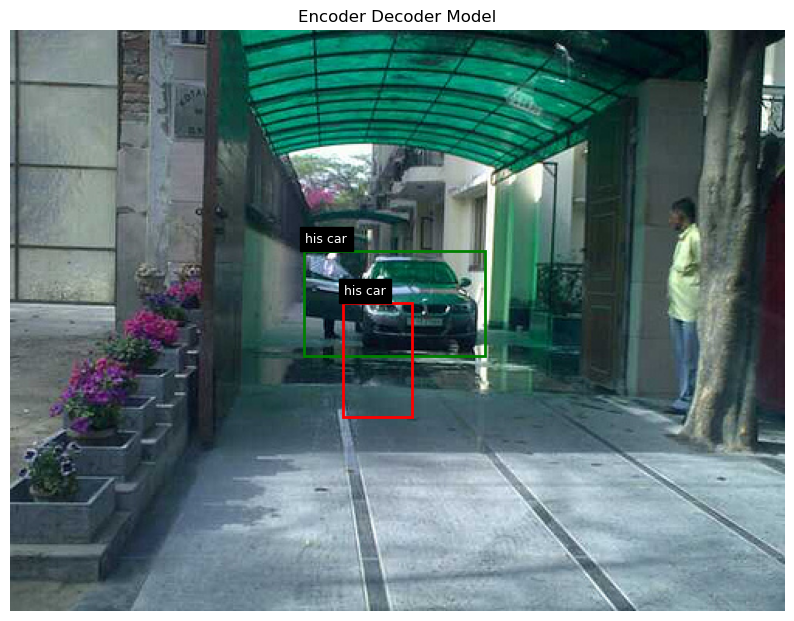

In [48]:
img_id = '3327761688'
phr_id =  '109678'
temp_frame = Test_Frame[Test_Frame['Image_Id'] == img_id][Test_Frame['Phrase_Id']== phr_id].reset_index()
img_name = temp_frame['Image_Id'][0]

_,_,img_path = get_Paths(image_name = img_name, _paths= _paths_dict)
img = Image.open(img_path)

phr = temp_frame['Phrase'][0]
ground_truth = temp_frame['Bounding_Box'].at[0]
play_Around(img, phr, model, 512, True, '/kaggle/working/enc_dec_sample1.png')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


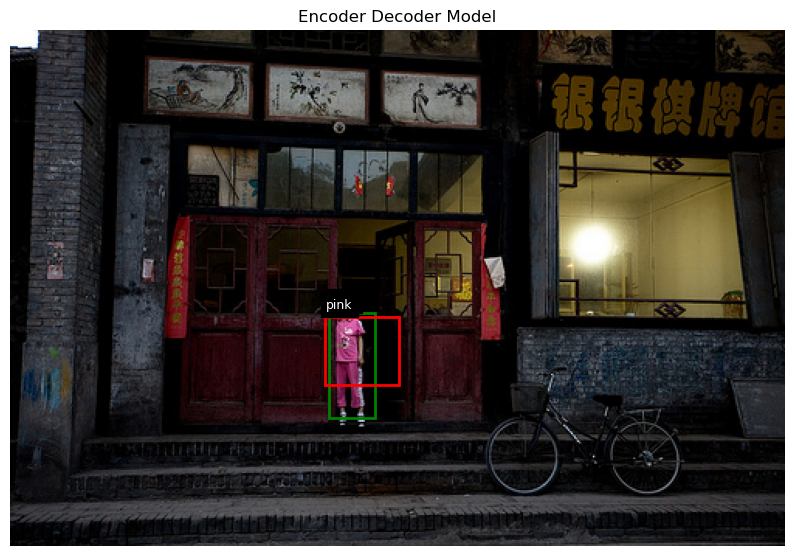

In [49]:
img_id = '4791513183'
phr_id = '203139'
temp_frame = Test_Frame[Test_Frame['Image_Id'] == img_id][Test_Frame['Phrase_Id']== phr_id].reset_index()
img_name = temp_frame['Image_Id'][0]

_,_,img_path = get_Paths(image_name = img_name, _paths= _paths_dict)
img = Image.open(img_path)

phr = temp_frame['Phrase'][0]
ground_truth = temp_frame['Bounding_Box'].at[0]
play_Around(img, phr, model, 512, True, '/kaggle/working/enc_dec_sample2.png')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


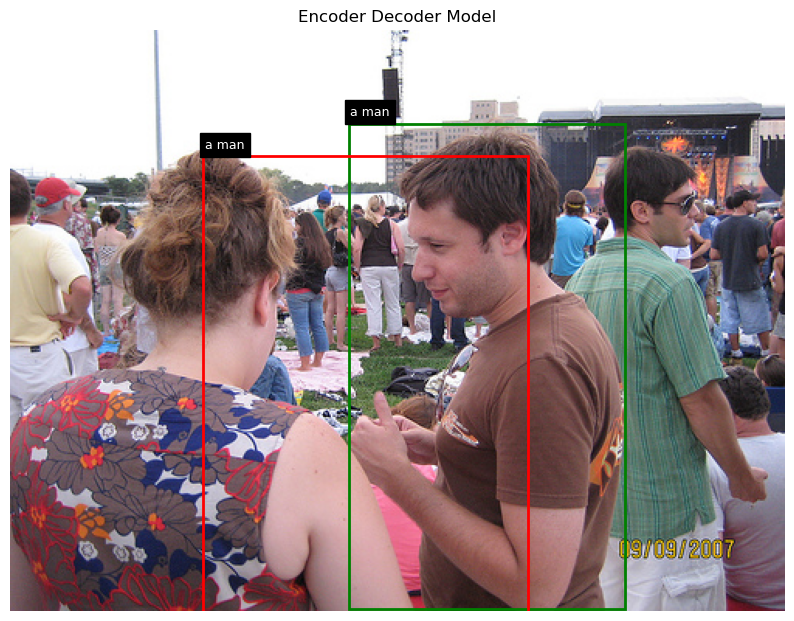

In [50]:
img_id = '1387014885'
phr_id =  '10771'
temp_frame = Test_Frame[Test_Frame['Image_Id'] == img_id][Test_Frame['Phrase_Id']== phr_id].reset_index()
img_name = temp_frame['Image_Id'][0]

_,_,img_path = get_Paths(image_name = img_name, _paths= _paths_dict)
img = Image.open(img_path)

phr = temp_frame['Phrase'][0]
ground_truth = temp_frame['Bounding_Box'].at[0]
play_Around(img, phr, model, 512, True, '/kaggle/working/enc_dec_sample3.png')